<a href="https://colab.research.google.com/github/RuHsu015/This_is_my_Colab/blob/main/time_series_forcasting_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 

import tensorflow as tf
from sklearn import preprocessing

import random
tf.random.set_seed(53)
random.seed(53)

In [3]:
BASE = "/content/drive/MyDrive/Colab Notebooks/deep_learning_report/Predict Future Sales/"
item_cat = pd.read_csv(BASE+"item_categories.csv")
item = pd.read_csv(BASE+"items.csv")
sales_train = pd.read_csv(BASE+"sales_train.csv")
shops = pd.read_csv(BASE+"shops.csv")
sales_test = pd.read_csv(BASE+"test.csv")

### data

In [56]:
def basic_eda(df):
    print("---------- TOP 5 RECORDS --------")
    print(df.head(5))
    print("---------- INFO -----------------")
    print(df.info())
    print("---------- Describe -------------")
    print(df.describe())
    print("---------- Columns --------------")
    print(df.columns)
    print("---------- Data Types -----------")
    print(df.dtypes)
    print("------- Missing Values ----------")
    print(df.isnull().sum())
    print("------- NULL values -------------")
    print(df.isna().sum())
    print("----- Shape Of Data -------------")
    print(df.shape)

**EDA**

In [57]:
print("============================= Sales Data =============================")
basic_eda(sales_train)

============================= Sales Data =============================
---------- TOP 5 RECORDS --------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
---------- INFO -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----

In [58]:
print("============================= Test data =============================")
basic_eda(sales_test)

============================= Test data =============================
---------- TOP 5 RECORDS --------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
---------- INFO -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
---------- Describe -------------
                  ID        shop_id        item_id
count  214200.000000  214200.000000  214200.000000
mean   107099.500000      31.642857   11019.398627
std     61834.358168      17.561933    6252.644590
min         0.000000       2.000000      30.000000
25%     53549.750000      16.000000    5381.500000
50%    107099.500000      34.500000   11

In [59]:
print("============================= Item Categories =============================")
basic_eda(item_cat)

============================= Item Categories =============================
---------- TOP 5 RECORDS --------
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
---------- INFO -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
---------- Describe -------------
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max        

In [60]:
print("============================= Items =============================")
basic_eda(item)

============================= Items =============================
---------- TOP 5 RECORDS --------
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
---------- INFO -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtype

In [61]:
print("============================= Shops =============================")
basic_eda(shops)

============================= Shops =============================
---------- TOP 5 RECORDS --------
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
---------- INFO -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
---------- Describe -------------
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000
---------- Columns --------------
Index(['shop_name', 'shop_id'], dtype='object')
---------- Data Types ----

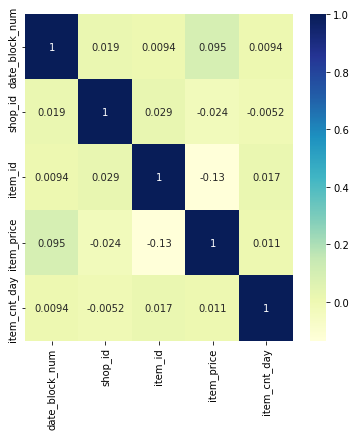

In [62]:
corr = sales_train.corr()
top_corr_features = corr.index[abs(corr["item_cnt_day"])>0]

plt.figure(figsize=(6,6))
g=sns.heatmap(sales_train[top_corr_features].corr(),annot=True,cmap="YlGnBu")

### data preprocess

**Data Preprocessing**

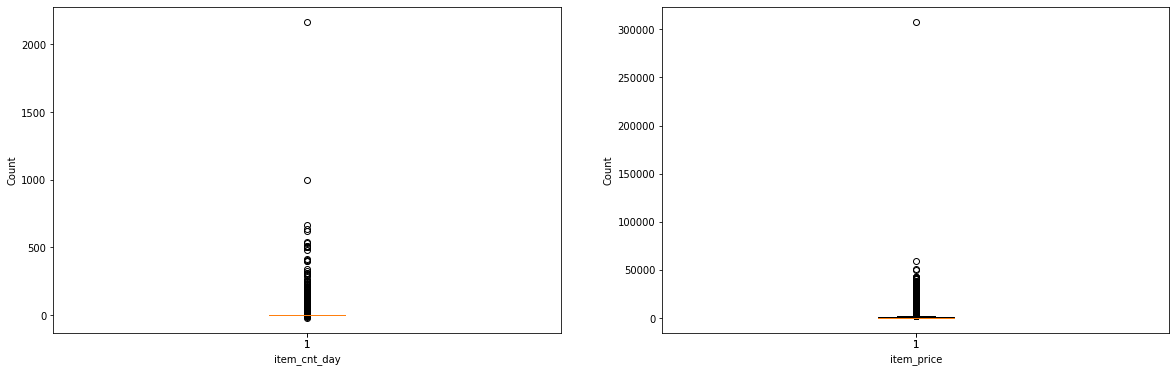

In [4]:
# Find outliers in the columns sales_train.'item_cnt_day',sales_train.'item_price'
cols = ['item_cnt_day','item_price']
fig, ax = plt.subplots(ncols = len(cols), figsize = (10 * len(cols),6), sharex = True)
fig.subplots_adjust(wspace=0.2)

for i in range(len(cols)):
  ax[i].boxplot(sales_train[cols[i]])
  ax[i].set_xlabel(cols[i])
  ax[i].set_ylabel("Count")

**Observations:**

item_cnt_day has outlier > 2000
item_price has outlier > 300000

**Next:**

Remove observed outliers

In [5]:
# Remove Outliers

outlier1 = sales_train[sales_train['item_cnt_day'] > 2000].index[0]
outlier2 = sales_train[sales_train['item_price'] > 300000].index[0]
sales_train.drop([outlier1,outlier2], axis = 0, inplace = True)

# Reset index

sales_train.reset_index(inplace=True,drop=True)
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935842,10.10.2015,33,25,7409,299.00,1.0
2935843,09.10.2015,33,25,7460,299.00,1.0
2935844,14.10.2015,33,25,7459,349.00,1.0
2935845,22.10.2015,33,25,7440,299.00,1.0


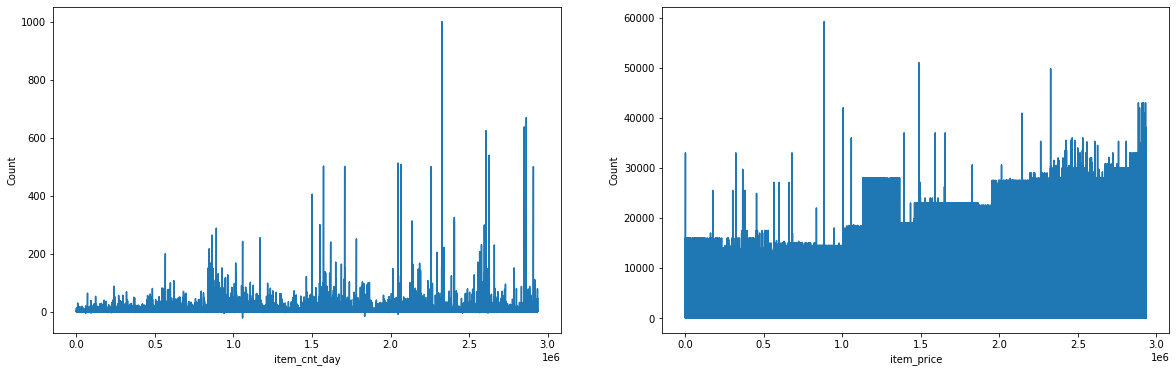

In [6]:
# Find anomalies in the columns sales_train.'item_cnt_day',sales_train.'item_price'
cols = ['item_cnt_day','item_price']
fig, ax = plt.subplots(ncols = len(cols), figsize = (10 * len(cols),6), sharex = True)
fig.subplots_adjust(wspace=0.2)

for i in range(len(cols)):
  ax[i].plot(sales_train[cols[i]])
  ax[i].set_xlabel(cols[i])
  ax[i].set_ylabel("Count")

**Observations:**

Column 'item_cnt_day' has some negative values which could be items that were 'returned'. Since we will be considering monthly counts, we will leave the negative values in there so that we get a correct count of items sold when we aggregrate by month

**Feature Engineering**

In [7]:
dataset = sales_train.pivot_table(index = ['shop_id','item_id', 'item_price'],
                  values = ['item_cnt_day'],
                  columns = ['date_block_num'],
                  fill_value = 0,
                 aggfunc='sum')

dataset

item_cnt_day                              ...     \
date_block_num                       0   1  2  3  4  5  6  7  8  9   ... 24   
shop_id item_id item_price                                           ...      
0       30      265.0                 0  31  0  0  0  0  0  0  0  0  ...  0   
        31      434.0                 0  11  0  0  0  0  0  0  0  0  ...  0   
        32      221.0                 6  10  0  0  0  0  0  0  0  0  ...  0   
        33      347.0                 3   3  0  0  0  0  0  0  0  0  ...  0   
        35      247.0                 1  14  0  0  0  0  0  0  0  0  ...  0   
...                                 ...  .. .. .. .. .. .. .. .. ..  ... ..   
59      22162   349.0                 0   0  0  0  0  0  0  0  0  0  ...  0   
                399.0                 0   0  0  0  0  0  0  0  0  0  ...  0   
        22164   699.0                 0   0  0  0  0  0  0  0  0  0  ...  0   
                749.0                 0   0  0  0  0  0  0  0  0  0  ...  0   
        22167   299.0                 0   0  0  0  0  0  0  0  0  1  ...  0   

                                                       
date_block_num             25 26 27 28 29 30 31 32 33  
shop_id item_id item_price                             
0       30      265.0       0  0  0  0  0  0  0  0  0  
        31      434.0       0  0  0  0  0  0  0  0  0  
        32      221.0       0  0  0  0  0  0  0  0  0  
        33      347.0       0  0  0  0  0  0  0  0  0  
        35      247.0       0  0  0  0  0  0  0  0  0  
...                        .. .. .. .. .. .. .. .. ..  
59      22162   349.0       0  0  1  1  0  0  1  0  0  
                399.0       9  4  0  0  0  0  0  0  0  
        22164   699.0       0  0  2  0  0  1  0  0  0  
                749.0       2  1  0  0  0  0  0  0  0  
        22167   299.0       0  0  0  0  0  0  0  0  0  

[737818 rows x 34 columns]

In [9]:
dataset.index

MultiIndex([( 0,    30,  265.0),
            ( 0,    31,  434.0),
            ( 0,    32,  221.0),
            ( 0,    33,  347.0),
            ( 0,    35,  247.0),
            ( 0,    36,  357.0),
            ( 0,    40,  127.0),
            ( 0,    42,  127.0),
            ( 0,    43,  221.0),
            ( 0,    49,  127.0),
            ...
            (59, 22150,  199.0),
            (59, 22151,  399.0),
            (59, 22153, 135.33),
            (59, 22154,  999.0),
            (59, 22155,  149.0),
            (59, 22162,  349.0),
            (59, 22162,  399.0),
            (59, 22164,  699.0),
            (59, 22164,  749.0),
            (59, 22167,  299.0)],
           names=['shop_id', 'item_id', 'item_price'], length=737818)

In [10]:
dataset.values[0]

array([ 0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [67]:
# # Combine the test_data to train_Data_Nov for prediction
# test_Data = sales_test.copy()
# test_Data = test_Data.pivot_table(index = ['shop_id','item_id'],fill_value = 0)
# Combine_train_test = pd.merge(test_Data, dataset, how = 'left', on = ['shop_id','item_id']).fillna(0)
# Combine_train_test = Combine_train_test.sort_values(by = 'ID')
# Combine_train_test.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  after removing the cwd from sys.path.


ID  (item_cnt_day, 0)  (item_cnt_day, 1)  (item_cnt_day, 2)  \
shop_id item_id                                                                
5       5037      0                0.0                0.0                0.0   
        5320      1                0.0                0.0                0.0   
        5233      2                0.0                0.0                0.0   
        5232      3                0.0                0.0                0.0   
        5268      4                0.0                0.0                0.0   
        5039      5                0.0                0.0                0.0   
        5041      6                0.0                0.0                0.0   
        5046      7                0.0                0.0                0.0   
        5319      8                0.0                0.0                0.0   
        5003      9                0.0                0.0                0.0   

                 (item_cnt_day, 3)  (item_cnt_day, 4)  (item_cnt_day, 5)  \
shop_id item_id                                                            
5       5037                   0.0                0.0                0.0   
        5320                   0.0                0.0                0.0   
        5233                   0.0                0.0                0.0   
        5232                   0.0                0.0                0.0   
        5268                   0.0                0.0                0.0   
        5039                   0.0                0.0                0.0   
        5041                   0.0                0.0                0.0   
        5046                   0.0                0.0                0.0   
        5319                   0.0                0.0                0.0   
        5003                   0.0                0.0                0.0   

                 (item_cnt_day, 6)  (item_cnt_day, 7)  (item_cnt_day, 8)  ...  \
shop_id item_id                                                           ...   
5       5037                   0.0                0.0                0.0  ...   
        5320                   0.0                0.0                0.0  ...   
        5233                   0.0                0.0                0.0  ...   
        5232                   0.0                0.0                0.0  ...   
        5268                   0.0                0.0                0.0  ...   
        5039                   0.0                0.0                0.0  ...   
        5041                   0.0                0.0                0.0  ...   
        5046                   0.0                0.0                0.0  ...   
        5319                   0.0                0.0                0.0  ...   
        5003                   0.0                0.0                0.0  ...   

                 (item_cnt_day, 24)  (item_cnt_day, 25)  (item_cnt_day, 26)  \
shop_id item_id                                                               
5       5037                    2.0                 0.0                 0.0   
        5320                    0.0                 0.0                 0.0   
        5233                    0.0                 0.0                 0.0   
        5232                    0.0                 0.0                 0.0   
        5268                    0.0                 0.0                 0.0   
        5039                    1.0                 0.0                 0.0   
        5041                    0.0                 0.0                 0.0   
        5046                    0.0                 0.0                 1.0   
        5319                    9.0                 2.0                 3.0   
        5003                    0.0                 0.0                 0.0   

                 (item_cnt_day, 27)  (item_cnt_day, 28)  (item_cnt_day, 29)  \
shop_id item_id                                                               
5       5037                    0.0                 1.0        

In [47]:
# Combine_train_test.index[0][1]

5037

In [69]:
# Combine_train_test.columns

Index([                'ID',  ('item_cnt_day', 0),  ('item_cnt_day', 1),
        ('item_cnt_day', 2),  ('item_cnt_day', 3),  ('item_cnt_day', 4),
        ('item_cnt_day', 5),  ('item_cnt_day', 6),  ('item_cnt_day', 7),
        ('item_cnt_day', 8),  ('item_cnt_day', 9), ('item_cnt_day', 10),
       ('item_cnt_day', 11), ('item_cnt_day', 12), ('item_cnt_day', 13),
       ('item_cnt_day', 14), ('item_cnt_day', 15), ('item_cnt_day', 16),
       ('item_cnt_day', 17), ('item_cnt_day', 18), ('item_cnt_day', 19),
       ('item_cnt_day', 20), ('item_cnt_day', 21), ('item_cnt_day', 22),
       ('item_cnt_day', 23), ('item_cnt_day', 24), ('item_cnt_day', 25),
       ('item_cnt_day', 26), ('item_cnt_day', 27), ('item_cnt_day', 28),
       ('item_cnt_day', 29), ('item_cnt_day', 30), ('item_cnt_day', 31),
       ('item_cnt_day', 32), ('item_cnt_day', 33)],
      dtype='object')

In [70]:
# combine = Combine_train_test.drop('ID', axis=1)
# combine.columns

Index([ ('item_cnt_day', 0),  ('item_cnt_day', 1),  ('item_cnt_day', 2),
        ('item_cnt_day', 3),  ('item_cnt_day', 4),  ('item_cnt_day', 5),
        ('item_cnt_day', 6),  ('item_cnt_day', 7),  ('item_cnt_day', 8),
        ('item_cnt_day', 9), ('item_cnt_day', 10), ('item_cnt_day', 11),
       ('item_cnt_day', 12), ('item_cnt_day', 13), ('item_cnt_day', 14),
       ('item_cnt_day', 15), ('item_cnt_day', 16), ('item_cnt_day', 17),
       ('item_cnt_day', 18), ('item_cnt_day', 19), ('item_cnt_day', 20),
       ('item_cnt_day', 21), ('item_cnt_day', 22), ('item_cnt_day', 23),
       ('item_cnt_day', 24), ('item_cnt_day', 25), ('item_cnt_day', 26),
       ('item_cnt_day', 27), ('item_cnt_day', 28), ('item_cnt_day', 29),
       ('item_cnt_day', 30), ('item_cnt_day', 31), ('item_cnt_day', 32),
       ('item_cnt_day', 33)],
      dtype='object')

In [11]:
new_dataset = dataset.reset_index()
new_dataset.columns

MultiIndex([(     'shop_id', ''),
            (     'item_id', ''),
            (  'item_price', ''),
            ('item_cnt_day',  0),
            ('item_cnt_day',  1),
            ('item_cnt_day',  2),
            ('item_cnt_day',  3),
            ('item_cnt_day',  4),
            ('item_cnt_day',  5),
            ('item_cnt_day',  6),
            ('item_cnt_day',  7),
            ('item_cnt_day',  8),
            ('item_cnt_day',  9),
            ('item_cnt_day', 10),
            ('item_cnt_day', 11),
            ('item_cnt_day', 12),
            ('item_cnt_day', 13),
            ('item_cnt_day', 14),
            ('item_cnt_day', 15),
            ('item_cnt_day', 16),
            ('item_cnt_day', 17),
            ('item_cnt_day', 18),
            ('item_cnt_day', 19),
            ('item_cnt_day', 20),
            ('item_cnt_day', 21),
            ('item_cnt_day', 22),
            ('item_cnt_day', 23),
            ('item_cnt_day', 24),
            ('item_cnt_day', 25),
            ('

In [12]:
new_dataset.head(3)

shop_id item_id item_price item_cnt_day                     \
date_block_num                                       0   1  2  3  4  5  6   
0                    0      30      265.0            0  31  0  0  0  0  0   
1                    0      31      434.0            0  11  0  0  0  0  0   
2                    0      32      221.0            6  10  0  0  0  0  0   

                ...                                
date_block_num  ... 24 25 26 27 28 29 30 31 32 33  
0               ...  0  0  0  0  0  0  0  0  0  0  
1               ...  0  0  0  0  0  0  0  0  0  0  
2               ...  0  0  0  0  0  0  0  0  0  0  

[3 rows x 37 columns]

In [14]:
new_dataset.values[0][1]

30.0

In [92]:
item.columns

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

In [ ]:
# add item_cat to dataset


In [21]:
item.loc[item['item_id'] == 30].values[0][2]

40

In [74]:
sales_train.shape

(2935847, 6)

In [75]:
# Combine_train_test.shape

(214200, 35)

In [76]:
# combine.shape

(214200, 36)

In [22]:
# Drop the ID
# Combine_train_test = Combine_train_test.drop(columns = ['ID'])

# Train Data
X_train = np.array(new_dataset.values[:,:-1]).reshape(np.array(new_dataset.values[:,:-1]).shape[0],np.array(new_dataset.values[:,:-1]).shape[1], 1)

# The target 
y_train = new_dataset.values[:,-1:]

X_test = np.array(new_dataset.values[:,1:]).reshape(np.array(new_dataset.values[:,1:]).shape[0],np.array(new_dataset.values[:,1:]).shape[1], 1)

In [23]:
X_train[0].shape

(36, 1)

In [24]:
y_train[0].shape

(1,)

**Data Preparation**

In [25]:
# dataset.reset_index(inplace = True)
# dataset = pd.merge(sales_test,dataset,on = ['item_id','shop_id'],how = 'left')
# dataset
# dataset.fillna(0,inplace = True)
# dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
# dataset.shape

# X we will keep all columns execpt the last one 
# X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
# y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
# X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
# print(X_train.shape,y_train.shape,X_test.shape)

**Model Training and Prediction**

In [26]:
Model_Check_point = tf.keras.callbacks.ModelCheckpoint("Model.h5", 
                             monitor = 'val_loss',
                             verbose = 1, 
                             save_best_only = True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=0, 
                            mode='auto')

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                            factor=0.5,
                            patience=5)

call_backs = [early_stopping_callback, lr_reducer, Model_Check_point]

In [28]:
def build_model():  
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True), input_shape=(36, 1)))
    # model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())   
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(1, activation="relu"))    
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = 'mse', metrics=['mse'])
    
    model.summary()  
    
    return model

model = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 36, 100)          20800     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 100)           0         
                                                                 
 flatten_1 (Flatten)         (None, 3600)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                115232    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 136,065
Trainable params: 136,065
Non-trainable params: 0
________________________________________________

In [29]:
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, batch_size = 512, verbose = 1, callbacks = call_backs)

Epoch 1/100
 415/1153 [=========>....................] - ETA: 2:08 - loss: 4.0526 - mse: 4.0526

KeyboardInterrupt: ignored

In [84]:
history_1 = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, batch_size = 512, verbose = 1, callbacks = call_backs)

Epoch 1/100
333/335 [============================>.] - ETA: 0s - loss: 6.5133 - mse: 6.5133
Epoch 1: val_loss improved from inf to 0.76408, saving model to Model.h5
335/335 [==============================] - 10s 19ms/step - loss: 6.4836 - mse: 6.4836 - val_loss: 0.7641 - val_mse: 0.7641 - lr: 0.0020
Epoch 2/100
334/335 [============================>.] - ETA: 0s - loss: 5.0803 - mse: 5.0803
Epoch 2: val_loss improved from 0.76408 to 0.75183, saving model to Model.h5
335/335 [==============================] - 6s 17ms/step - loss: 5.0711 - mse: 5.0711 - val_loss: 0.7518 - val_mse: 0.7518 - lr: 0.0020
Epoch 3/100
334/335 [============================>.] - ETA: 0s - loss: 5.6090 - mse: 5.6090
Epoch 3: val_loss did not improve from 0.75183
335/335 [==============================] - 6s 17ms/step - loss: 5.5986 - mse: 5.5986 - val_loss: 0.9472 - val_mse: 0.9472 - lr: 0.0020
Epoch 4/100
334/335 [============================>.] - ETA: 0s - loss: 4.4166 - mse: 4.4166
Epoch 4: val_loss did not imp

In [ ]:
# loss, acc = model.evaluate(test_data, test_labels)
# loss, acc

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  mse = history.history['mse']
  val_mse = history.history['val_mse']

  epochs = range(len(history.history['loss']))

  # 設置統一刻度間距及範圍
  # x_major_locator = MultipleLocator(1)
  # y_major_locator = MultipleLocator(0.05)
  
  # ax=plt.gca()
  # ax.xaxis.set_major_locator(x_major_locator)
  # ax.yaxis.set_major_locator(y_major_locator)
  # plt.xlim(0, 10)
  pd.DataFrame(history.history).plot(figsize=(10,7));

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, mse, label='training_mse')
  plt.plot(epochs, val_mse, label='val_mse')
  plt.title('MSE')
  plt.xlabel('Epochs')
  plt.legend();['val_loss']

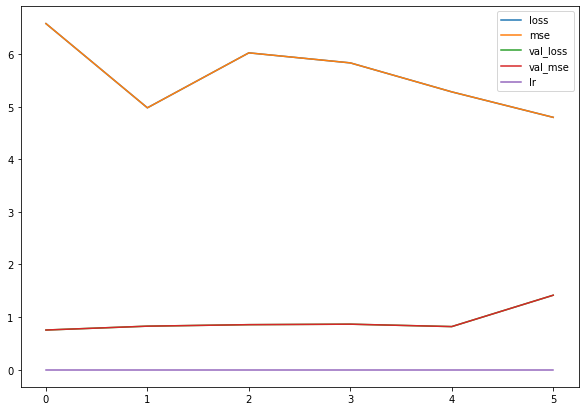

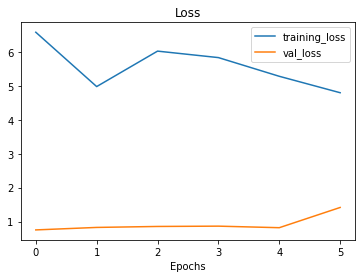

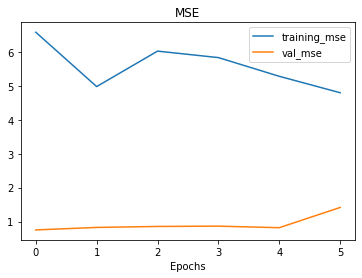

In [89]:
import matplotlib.pyplot as plt
plot_loss_curves(history)

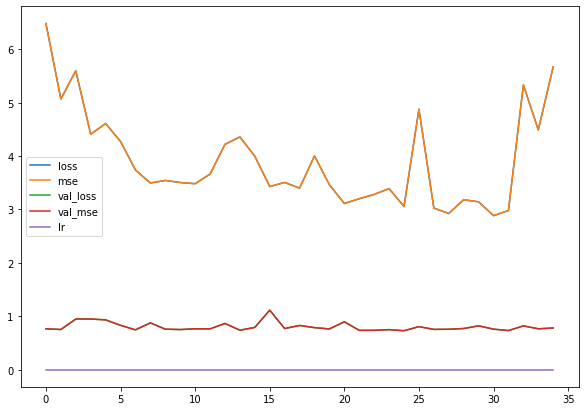

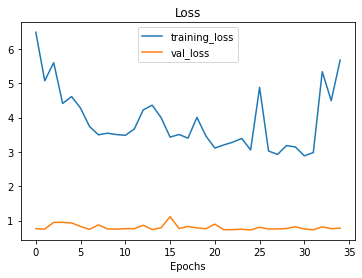

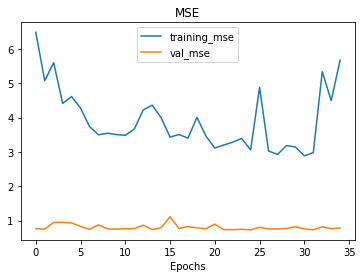

In [85]:
import matplotlib.pyplot as plt
plot_loss_curves(history_1)

In [ ]:
model = tf.keras.models.load_model('./Model.h5')

**Submit Predictions**

In [26]:
submission = pd.DataFrame(sales_test['ID'])
submission['item_cnt_month'] = model.predict(X_test)
submission.to_csv('/content/drive/MyDrive/submission.csv',index = False)
submission

,ID,item_cnt_month
0,0,0.480403
1,1,0.121278
2,2,0.803945
3,3,0.120438
4,4,0.121278
...,...,...
214195,214195,0.412207
214196,214196,0.121278
214197,214197,0.115950
214198,214198,0.121278
